# Perspektiva obrazu - měření závitu
Cvičení je pokračováním cvičení zaměřeného na práci s polárními souřadnicemi při využití nestandardních 360° objektivů od firmy [Opto Engineering](https://www.opto-e.com/). Způsob použití takových objektivů je demonstrován v [tutoriálu](https://www.opto-e.com/resources/peripheric-optics-tutorial) na stránkách výrobce. Ve cvičení jsou použita data získaná z optického systému typu boroskopická sonda.

## Boroskopická sonda
[Boroskopická sonda](https://www.opto-e.com/products/boroscopic-probes#Insight) díky zrcadlu umožňuje podívat se 360 ° dokola kolem sebe. Typickými aplikacemi jsou průmyslové inspekce děr či kontroly správnosti závitů. 

<img src="images/boro.jpg" width="30%">

## Teorie k měření
Matice s metrickým závitem jsou podle norem ČSN ISO 261, 262 definovány pomocí písmene `M` a číslice `průměru závitu` v názvu. Dále jsou definovány veličiny `stoupání závitu`, které lze rozdělit na **standardní, m** (metric) a **jemná stoupání, m-f, m-f2, m-f3** (metric-fine). Průměr závitu (D) je definován v mm, stoupání závitu (P) je také definováno v mm. 

<img src="images/uhel1.webp" height="250px"><img src="images/uhel2.webp" height="250px">

Specifickou veličinou je `úhel stoupání` ($\varphi$), který může být využit jako poznávací znamení. Je definován jako:

$$\varphi = \arctan \left(\frac{P}{\pi D} \right)$$

*Obrázky i vzorce jsou přejaty z webu [ZDE](https://www.sandvik.coromant.com/cs-cz/knowledge/machining-formulas-definitions/pages/threading.aspx). Stejně tak tam lze najít více informací k tématu, pokud by někoho zaujalo.*

---

### Import knihoven a konfigurace
Některé funkce jsou k dispozici ve vlastním souboru s názvem `library.py`. Jedná se hlavně o drobnosti použitelné pro tohle cvičení.

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

from improutils import *

np.set_printoptions(precision=3)

%matplotlib inline
%run library.py

### Pomocné funkce
Z následujících funkcí je potřeba vybírat ty vhodné pro splnění úkolu.

Seznam funkcí pro přehlednost:
- [`load_image(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/acquisition/img_io.py#L11)
- [`plot_images(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/visualisation/visualisation.py#L11)


- [`to_gray(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/preprocessing/preprocessing.py#L4)
- [`crop(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/preprocessing/preprocessing.py#L94)


- [`segmentation_one_threshold(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/segmentation/segmentation.py#L50)
- [`segmentation_auto_threshold(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/segmentation/segmentation.py#L67)
- [`segmentation_two_thresholds(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/segmentation/segmentation.py#L82)
- [`segmentation_adaptive_threshold(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/segmentation/segmentation.py#L100)


- [`filtration_median(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/filtration/filtration.py#L21)


- [`warp_to_cartesian(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/preprocessing/preprocessing.py#L216)
- [`warp_to_polar(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/preprocessing/preprocessing.py#L220)
- [`rotate(...)`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/preprocessing/preprocessing.py#L176)

---

### Úkol
Cílem úlohy je poznat, která matice byla snímána pomocí boroskopické sondy. Následujícím způsobem jsou zadány hodnoty jednotlivých matic s metrickým závitem.

|Název  |D (mm) | P, m (mm) | P, m-f (mm)   | P, m-f2 (mm)  |
| -     | :---  | :-------  | :-------      | :-------      |
|M22 |22 |2.5 |2 |1.5 |
|M24 |24 |3 	|2	|1.5 |
|M30 |30 |3.5   |2  |1.5 |
|M36 |36 |4	    |3	|2 |

atd.

Obrázek ukazuje, co je to matice a jejich různé velikosti. Je čistě ilustrační.

<img src="images/various_nuts.jpg" width="30%">

In [2]:
# Databáze matic z normy
# name: d, m, f, f2
nuts = {
    'M22':	[22,	2.5,	2,	1.5],
    'M24':	[24,	3,	2,	1.5],
    'M30':	[30,	3.5,	2,	1.5],
    'M36':	[36,	4,	3,	2],
    'M42':	[42,	4.5,	3,	2],
    'M48':	[48,	5,	3,	2],
    'M52':	[52,	5,	3,	2],
    'M56':	[56,	5.5,	4,	2],
    'M60':	[60,	5.5,	4,	2],
    'M64':	[64,	6,	4,	3],
    'M68':	[68,	6,	4,	3],
    'M72':	[72,	6,	4,	2],
    'M76':	[76,	6,	4,	2],
    'M80':	[80,	6,	4,	2],
    'M90':	[90,	6,	4,	2],
    'M100':	[100,	6,	4,	2],
    'M110':	[110,	6,	4,	2],
    'M120':	[120,	6,	4,	2],
    'M125':	[125,	6,	4,	2]
}

Ps = ['m', 'm-f', 'm-f2']

#### 1) Načtení a předzpracování
Načtěte obrázek matice snímané pomocí boroskopické sondy. Obrázek je čtvercový. Vytvořte z něj obdélníkový obrázek závitu pomocí vhodného převodu mezi souřadnými systémy. Rotujte obrázek tak, aby vnitřek kruhu byl na spodní straně obdélníku (viz [dokumentace OpenCV](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga49481ab24fdaa0ffa4d3e63d14c0d5e4)). Obrázky zobrazte.

(2079, 662)


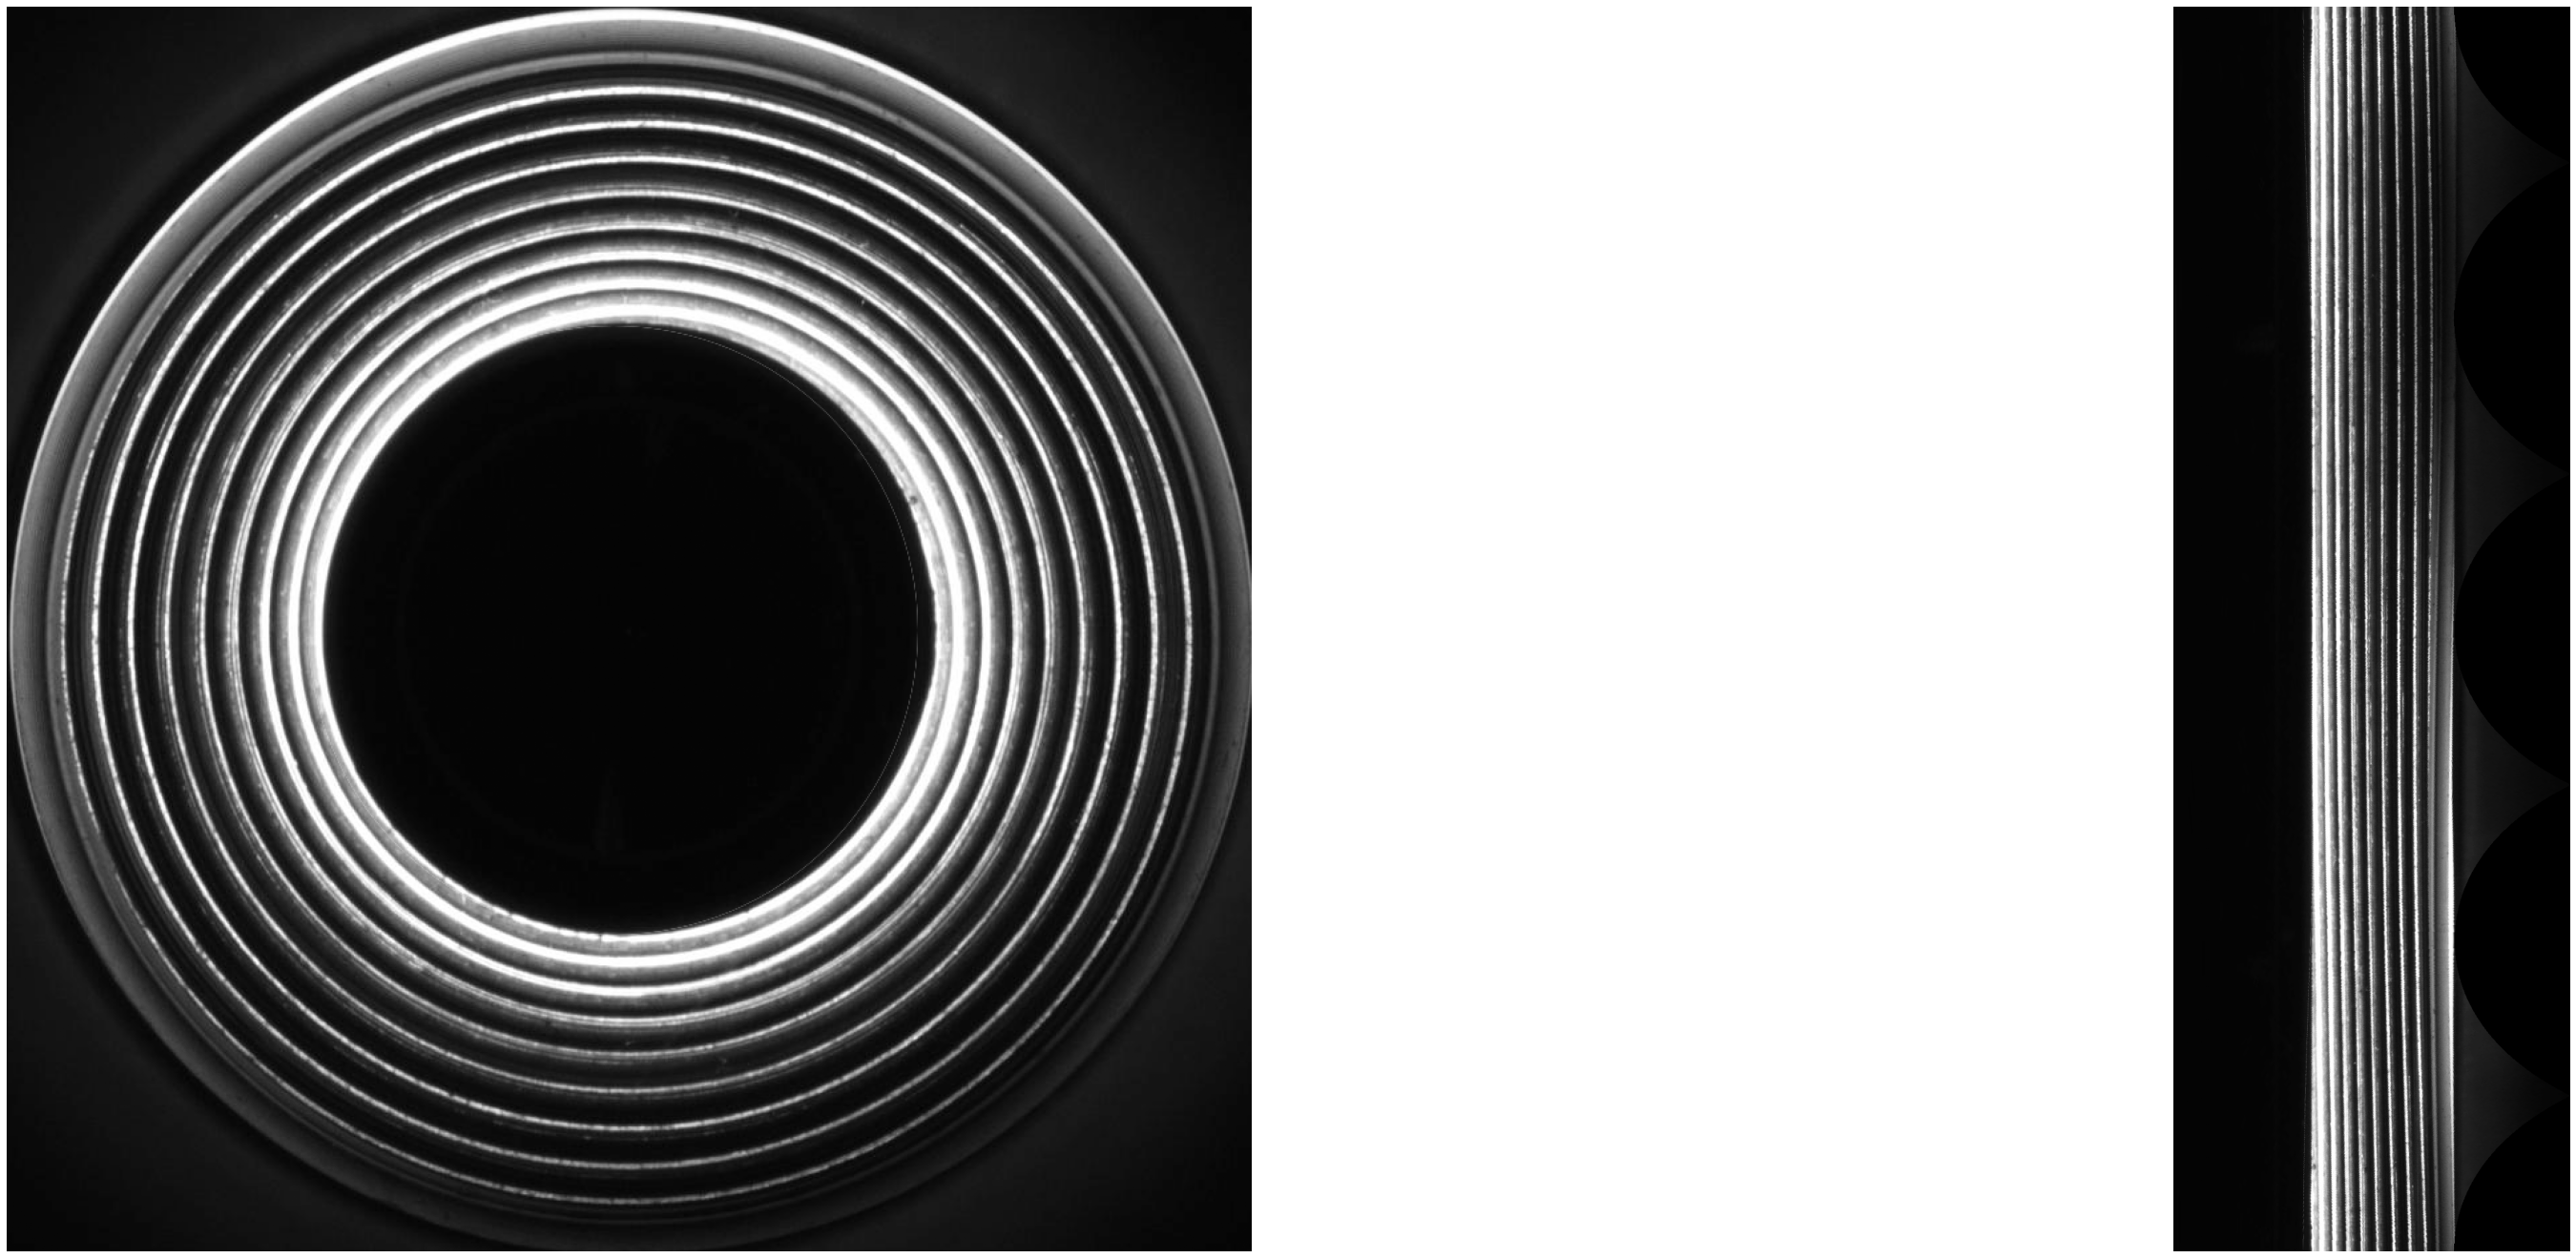

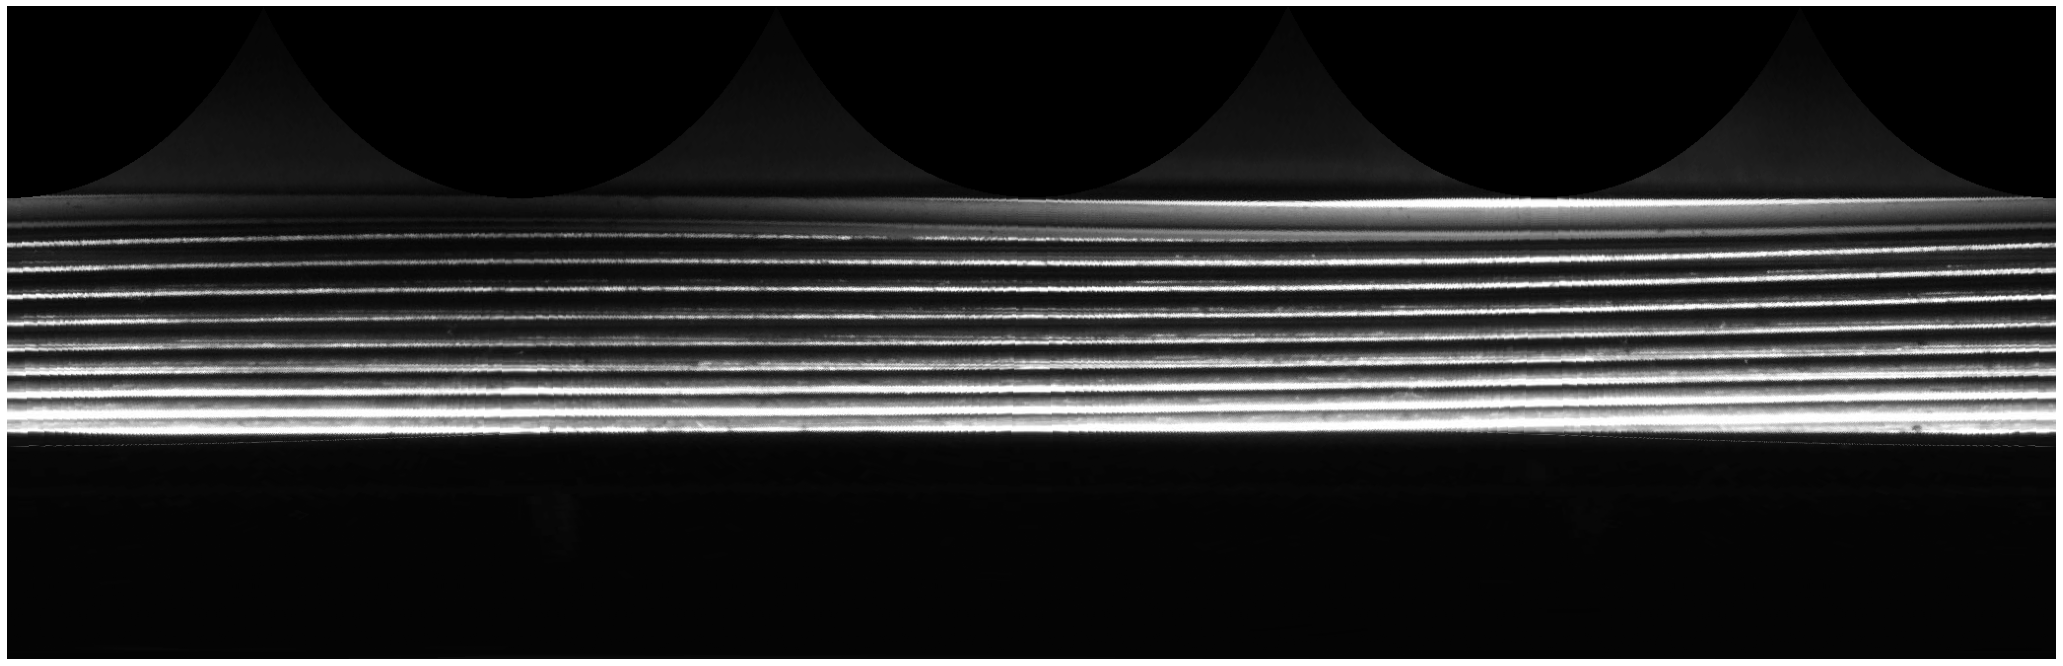

In [3]:
image_path = 'data/boro_nut.png' ### cesta k obrázku
image_grey = to_gray(load_image(image_path)) ### načtení obrazu

image_trans = warp_to_cartesian(image_grey) ### správná transformace
print(image_trans.shape)

img_rotated = rotate(image_trans, 90) ###

# Zobrazí obrázky
plot_images(image_grey, image_trans)
plot_images(img_rotated)

#### 2) Segmentace
Automaticky segmentujte část obrazu (vytvořte masku) obsahující pouze závit. Ořízněte obrázek podle vytvořené masky - výsledek lze vylepšit přidáním konstanty na ořez nahoře a dole, kde je závit špatně viditelný. Zobrazte obrázek.

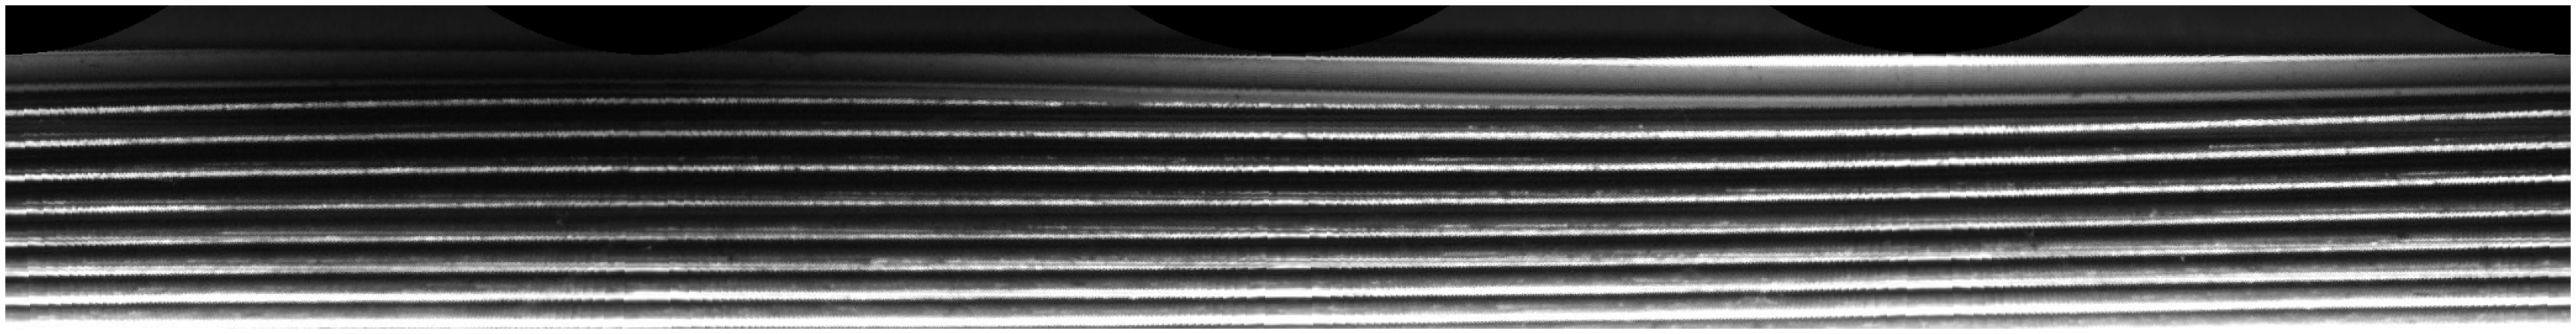

In [13]:
img_bin = segmentation_one_threshold(img_rotated, 30) ### segmentace
tl_x, tl_y, w, h = cv2.boundingRect(img_bin) 

crop_const = 30 ### vlastní konstanta
img_crop = crop(img_rotated, tl_x, tl_y + crop_const, tl_x + w, tl_y + h - crop_const) ### ořez
plot_images(img_crop)

#### 3) Detekce závitů
Pro předzpracování obrazu využijte filtr vhodný pro zachování hran. Seznamte se a experimentujte s hranovým detektorem typu [Canny](https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html) pro detekci hran - závitů. Obrázek hran zobrazte.

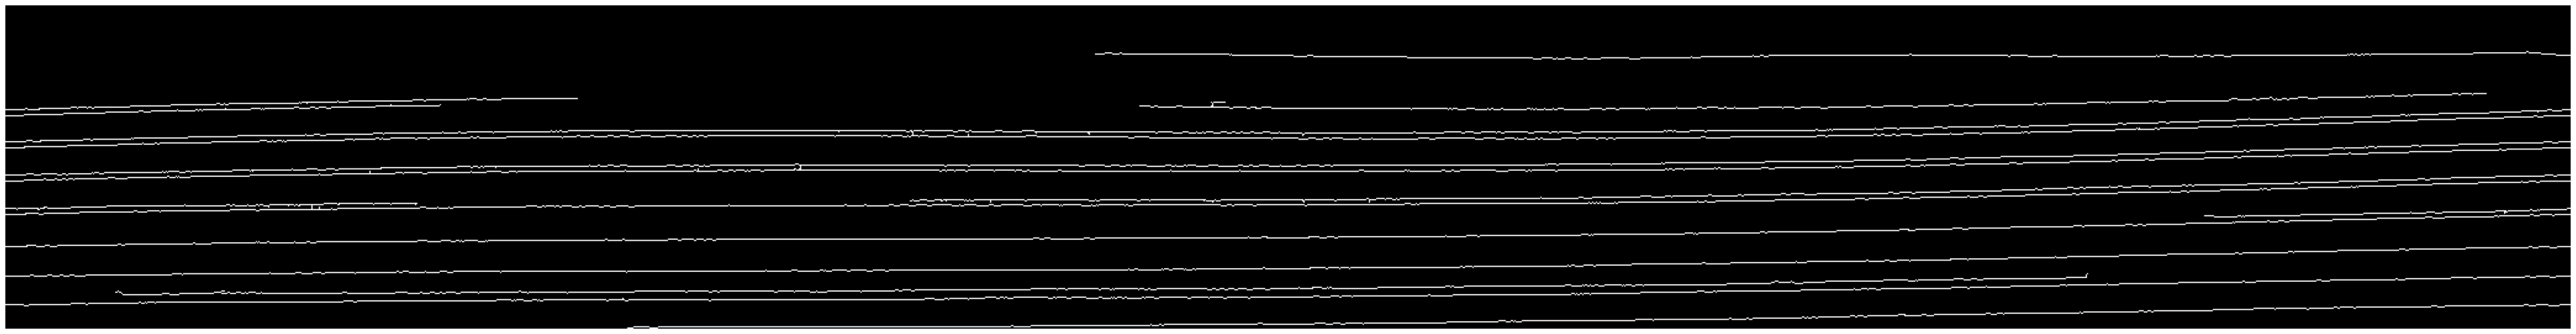

In [51]:
img_filtered = filtration_median(img_crop, 5) ### 

img_edges = cv.Canny(img_filtered, 150, 500) ### hranový detektor s vhodnými parametry

plot_images(img_edges)

#### 4) Zisk geometrických charakteristik
Aproximujte nalezené hrany pomocí přímek (úseček). K aproximaci se seznamte a experimentujte s metodou [Houghovy](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) (*čti hafovy*) transformace. Obzvlášť vhodná je metoda pravděpodobnostní Houghovy transformace (`HoughLinesP`). 

Nastavte parametry funkce tak, aby hledala pouze delší čáry (ideálně delší než 300 px klidně s větší mezerou). Vhodný počet čar jsou jednotky až desítky. Samozřejmě ideální čáry jsou ty, které kopírují směr závitu.

Vykreslete čáry do obrázku a ten zobrazte. Můžete využít funkci `draw_lines()`.

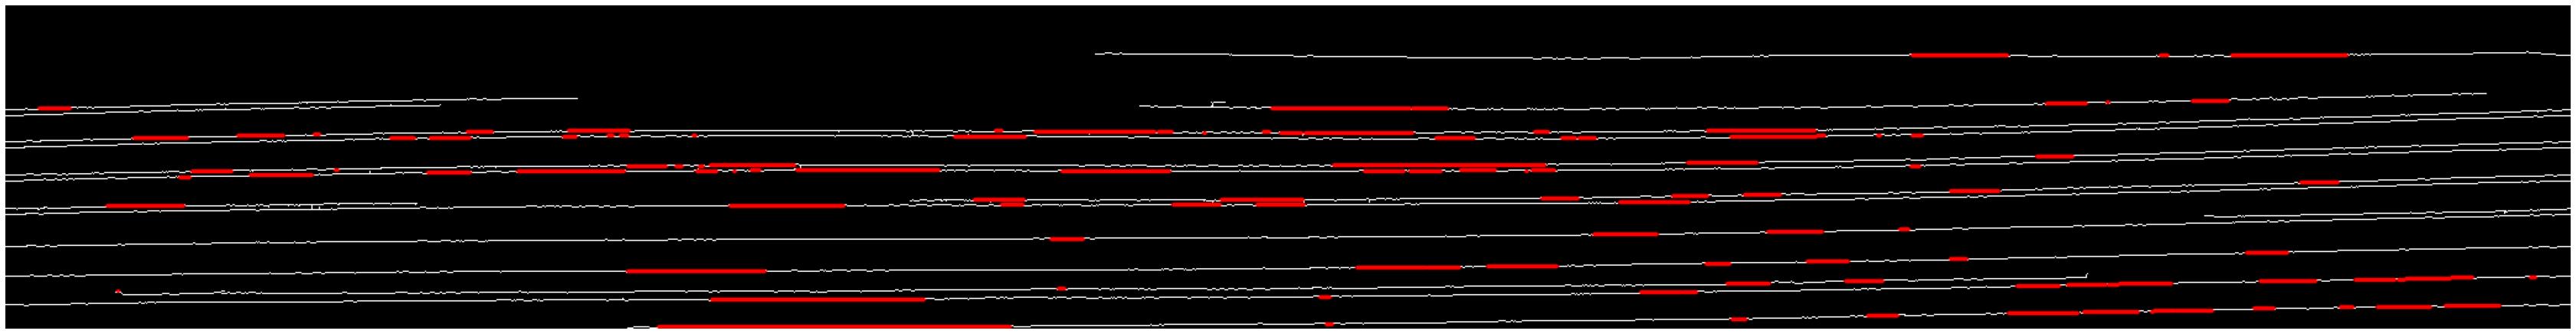

In [53]:
linesP = cv.HoughLinesP(img_edges, 1, np.pi / 180, 300, None, 0, 0) ### transformace s vhodnými parametry
img_lines = draw_lines(img_edges, linesP) ### kreslení

plot_images(img_lines)

#### 5) Spočítejte úhel stoupání závitu
Pro všechny nalezené přímky **spočítejte** `úhel stoupání závitu`. 

Vzhledem k nedokonalosti v převodu obrazu z polárních souřadnic je vhodné nalezené přímky filtrovat s použitím spočteného úhlu a délky. Nemá smysl započítávat přímky, jejichž pomyslný trojúhelník žádný úhel nesvírá, stejně tak, jako přímky kratší než např. polovina délky snímku.

Použijte **vhodnou metodu** pro určení **jedné hodnoty** úhlu stoupání ze všech spočtených. Hodnotu úhlu stoupání zobrazte ve **stupních**.

In [65]:
from math import atan
angles = list()
for line in linesP:
    ### výpočet
    vector = np.array((line[0][2] - line[0][0], line[0][3] - line[0][1]))
    angle = atan(vector[1] / (vector[0] * np.pi))
    
    # vhodná podmínka
    if vector[1] > 0:
        print('here')
        angles.append(angle) 
        
angle_rad = np.mean(angles) ### vhodná metoda
print(angles)
print(str(angle_rad) + ' rad')

angle_deg = np.rad2deg(angle_rad) ### převod
print(str(angle_deg) + ' °')

[]
nan rad
nan °


invalid value encountered in int_scalars
Mean of empty slice.
invalid value encountered in double_scalars


#### 6) Bonusová část - Identifikujte matici 
Nalezněte konkrétní typ snímané matice z databáze `nuts` (proměnná zadefinovaná výše). Výsledek vypište ve tvaru: `název, typ stoupání závitu`. 

Co dalšího byste potřebovali vědět pro ještě přesnější identifikaci matice?

In [ ]:
### Výpočty a klasifikace

